In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import pchip_interpolate

from genetic_algorithm_pfm.genetic_algorithm_pfm.algorithm import GeneticAlgorithm

Set Weights for Different Objectives

In [35]:
def objective_p1(X):
    """
    Objective to minimize the costs.
    """
    L = X[:, 0]
    B = X[:, 1] 
    H = 6
    c1 = 0.8e3
    F1 = (L * B * H) * c1
    p_value = pchip_interpolate([3e7, 12e7, 24e7], [100,65,0], F1)
    return p_value 


def objective_p2(X):
    """
    Objective to maximize the capacity.
    """
    L = X[:, 0]
    B = X[:, 1]
    L_avg = 213.0 
    B_avg = 45.5
    F2 = L * B /(L_avg*B_avg)
    p_value = pchip_interpolate([0, 3, 5], [0, 60, 100], F2)
    return p_value

def objective(X):
    """
    Objective function that is fed to the GA. Calles the separate preference functions that are declared above.

    :param variables: array with design variable values per member of the population. Can be split by using array
    slicing
    :return: 1D-array with aggregated preference scores for the members of the population.
    """
    # extract 1D design variable arrays from full 'variables' array

    # calculate the preference scores
    p_1 = objective_p1(X)
    p_2 = objective_p2(X)

    w1 = 0.5
    w2 = 0.5
    return [w1, w2], [p_1, p_2]

Define Constraints and Bounds


In [36]:
b1 = [270, 550]  # L
b2 = [30, 90]  # B

bounds = [b1, b2]

cons = []


Graphical Output


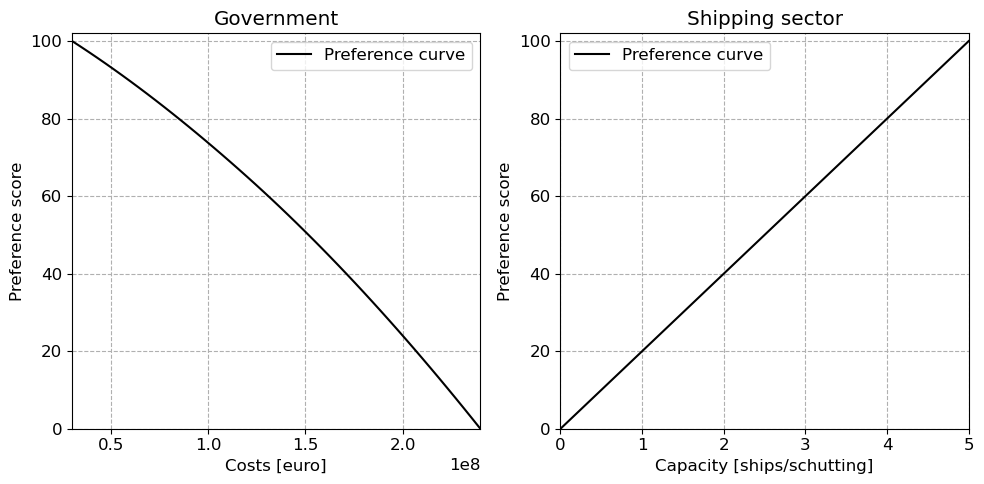

In [37]:
# create arrays for plotting continuous preference curves
c1 = np.linspace(3e7, 24e7)
c2 = np.linspace(0, 5)

# calculate the preference functions
p1 = pchip_interpolate([3e7, 12e7, 24e7], [100,65,0], (c1))
p2 = pchip_interpolate([0, 3, 5], [0, 60, 100], (c2))

# create figure that plots all preference curves and the preference scores of the returned results of the GA
fig = plt.figure(figsize=((10,5)))

font1 = {'size':20}
font2 = {'size':15}

plt.rcParams['font.size'] = '12'
plt.rcParams['savefig.dpi'] = 300

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(c1, p1, label='Preference curve', color='black')

ax1.set_xlim((3e7, 24e7))
ax1.set_ylim((0, 102))
ax1.set_title('Government')
ax1.set_xlabel('Costs [euro]')
ax1.set_ylabel('Preference score')
ax1.grid()
ax1.grid(linestyle = '--')

#fig = plt.figure()
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(c2, p2, label='Preference curve', color='black')
ax2.set_xlim((0, 5))
ax2.set_ylim((0, 102))
ax2.set_title('Shipping sector')
ax2.set_xlabel('Capacity [ships/schutting]')
ax2.set_ylabel('Preference score')
ax2.grid()
ax2.legend()
ax2.grid(linestyle = '--')

ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()

#Two  lines to make our compiler able to draw:
#fig.savefig("/home/ruud/engineeringdesign.education/static/urbanplanningproblemfunctions.png")

Optimization

Now we have everything for the optimization, we can run it. For more information about the different options to configure the GA, see the docstring of GeneticAlgorithm (via help()) or chapter 4 of the reader. Once we have the results, we can make some figures. First, the resulting design variables are plotted into the solution space. Secondly, we can plot the preference functions together with the results of the optimizations.



Run GA with minmax
The type of aggregation is set to minmax
Generation   Best score   Mean             Max stall    Diversity    Number of non-feasible results
0            20.9981      29.4799          0            0.007        0           
1            20.9981      25.2535          1            0.118        0           
2            20.9981      22.9637          2            0.426        0           
3            20.9981      21.8733          3            0.454        0           
4            20.9981      21.7622          4            0.461        0           
5            20.9981      21.5866          5            0.458        0           
6            20.9981      21.5115          6            0.46         0           
7            20.9774      21.5899          0            0.455        0           
8            20.9774      21.9729          1            0.272        0           
9            20.9774      21.7257          2            0.453        0           
10           20.9774

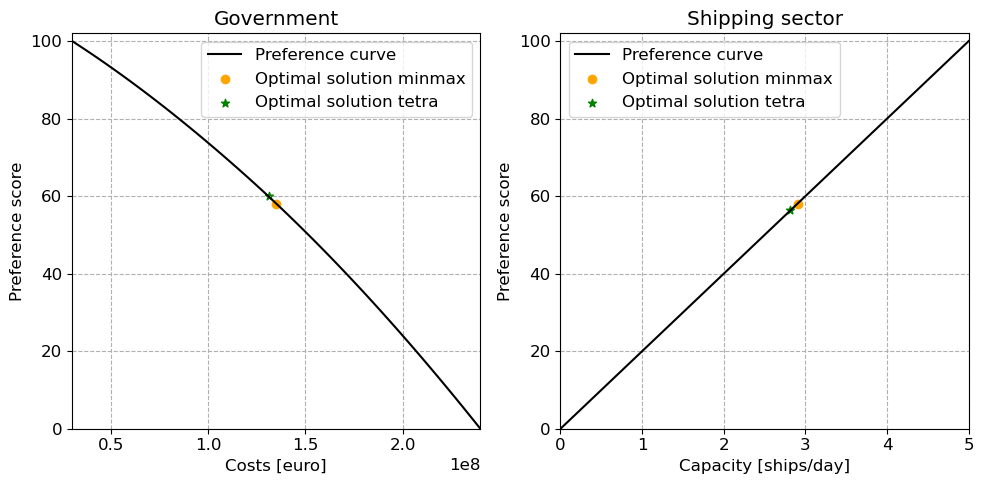

In [38]:
# We run the optimization with two paradigms
paradigm = ['minmax', 'tetra']
marker = ['o', '*']
colours = ['orange','green']

# The figure and axes are defined before the loop
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

for i in range(2):
    # make dictionary with parameter settings for the GA run with the IMAP solver
    options = {
        'n_bits': 8,
        'n_iter': 400,
        'n_pop': 500,
        'r_cross': 0.8,
        'max_stall': 8,
        'aggregation': paradigm[i], # minmax or tetra
        'var_type': 'real' 
    }
    
    # run the GA and print its result
    print(f'Run GA with ' + paradigm[i])
    ga = GeneticAlgorithm(objective=objective, constraints=cons, bounds=bounds, options=options)
    score_IMAP, design_variables_IMAP, _ = ga.run()
    
    # Calculate individual preference scores for the GA results
    c1_res = (design_variables_IMAP[0] * design_variables_IMAP[1] * 6) * 0.8e3
    p1_res = pchip_interpolate([3e7, 12e7, 24e7], [100,65,0], (c1_res))

    c2_res = (design_variables_IMAP[0]*design_variables_IMAP[1])/(213*45.5)
    p2_res = pchip_interpolate([0, 3, 5], [0, 60, 100], (c2_res))

    # Debugging prints to check the calculated values
    print(f"c1_res: {c1_res}, p1_res: {p1_res}")
    print(f"c2_res: {c2_res}, p2_res: {p2_res}")

    # Plot the preference curves 
    if i == 0:  # Only plot curves once
        c1 = np.linspace(3e7,24e7)
        c2 = np.linspace(0, 5)

        p1 = pchip_interpolate([3e7, 12e7, 24e7], [100,65,0], (c1))
        p2 = pchip_interpolate([0, 3, 5], [0, 60, 100], (c2))

        ax1.plot(c1, p1, label='Preference curve', color='black')
        ax1.set_xlim((3e7,24e7))
        ax1.set_ylim((0, 102))
        ax1.set_title('Government')
        ax1.set_xlabel('Costs [euro]')
        ax1.set_ylabel('Preference score')
        ax1.grid()
        ax1.grid(linestyle = '--')

        ax2.plot(c2, p2, label='Preference curve', color='black')
        ax2.set_xlim((0, 5)) 
        ax2.set_ylim((0, 102))
        ax2.set_title('Shipping sector')
        ax2.set_xlabel('Capacity [ships/day]')
        ax2.set_ylabel('Preference score')
        ax2.grid()
        ax2.legend()
        ax2.grid(linestyle = '--')

    # Scatter the results on the preference curve plots
    ax1.scatter(c1_res, p1_res, label='Optimal solution ' + paradigm[i], color= colours[i], marker=marker[i])
    ax2.scatter(c2_res, p2_res, label='Optimal solution ' + paradigm[i], color=colours[i], marker=marker[i])

# Add legends and adjust layout after plotting all data points
ax1.legend()
ax2.legend()
fig.tight_layout()

# Display the plot
plt.show()

In [39]:
print("lengte is:",design_variables_IMAP[0])
print("breedte is:",design_variables_IMAP[1])

lengte is: 422.03125
breedte is: 64.6875
